<a href="https://colab.research.google.com/github/naufalnashif/test-case/blob/main/telkomsel/technical_skill_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EXPLORE Telecommunication CDRs Data of Trentino Italia From Harvard Dataverse

cc : [Naufal Nashif](https://www.linkedin.com/in/naufalnashif/)
| files : [Github](https://github.com/naufalnashif/test-case/tree/c7834a26f2cb0bf193fa1a37154b644f4ac432c4/telkomsel)

## Import Dependencies

In [28]:
import requests
from google.colab import userdata
import pandas as pd
from IPython.display import display
import os

## Init

In [60]:
dataset_url = "https://dataverse.harvard.edu/api/datasets/:persistentId?persistentId=doi:10.7910/DVN/QLCABU"
grid_dataset_url = "https://dataverse.harvard.edu/api/datasets/:persistentId?persistentId=doi:10.7910/DVN/FZRVSX"
api_token = userdata.get("HARVARD_API_TOKEN")

In [37]:
class Harvard_Dataset_Download:
    def __init__(self, dataset_url, api_token):
        self.dataset_url = dataset_url
        self.api_token = api_token

    def get_available_files(self):

        headers = {
            'X-Dataverse-key': self.api_token
        }
        response = requests.get(self.dataset_url, headers=headers)

        if response.status_code == 200:

            data = response.json()
            files = data['data']['latestVersion']['files']

            file_info = []

            for file in files:
                file_label = file['label']
                datafile_id = file['dataFile']['id']
                file_info.append({
                    'nama_file': file_label,
                    'datafile_id': datafile_id
                })

            return pd.DataFrame(file_info)
        else:
            print(f"Terjadi kesalahan saat mengambil metadata dataset: {response.status_code}, {response.text}")
            return None

    def download_files(self, num_files=30):

        df_files = self.get_available_files()

        if df_files is not None:

            df_files_to_download = df_files.head(num_files)

            if not os.path.exists('raw_data'):
                os.makedirs('raw_data')

            headers = {
                'X-Dataverse-key': self.api_token
            }

            for index, row in df_files_to_download.iterrows():
                file_name = row['nama_file']
                datafile_id = row['datafile_id']

                print(f"Menemukan file: {file_name} dengan datafile_id: {datafile_id}")


                file_url = f"https://dataverse.harvard.edu/api/access/datafile/{datafile_id}"


                file_response = requests.get(file_url, headers=headers)
                if file_response.status_code == 200:

                    file_path = os.path.join('raw_data', file_name)
                    with open(file_path, 'wb') as f:
                        f.write(file_response.content)
                    print(f"File {file_name} berhasil diunduh ke folder raw_data.")
                else:
                    print(f"Terjadi kesalahan saat mengunduh file {file_name}: {file_response.status_code}")
        else:
            print("Tidak ada file untuk diunduh.")



## Get The Data

In [38]:
dataset_downloader = Harvard_Dataset_Download(dataset_url, api_token)
dataset_downloader.download_files(num_files=30)

Menemukan file: sms-call-internet-tn-2013-11-01.txt dengan datafile_id: 2674712
File sms-call-internet-tn-2013-11-01.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-02.txt dengan datafile_id: 2674718
File sms-call-internet-tn-2013-11-02.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-03.txt dengan datafile_id: 2674726
File sms-call-internet-tn-2013-11-03.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-04.txt dengan datafile_id: 2674730
File sms-call-internet-tn-2013-11-04.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-05.txt dengan datafile_id: 2674734
File sms-call-internet-tn-2013-11-05.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-06.txt dengan datafile_id: 2674738
File sms-call-internet-tn-2013-11-06.txt berhasil diunduh ke folder raw_data.
Menemukan file: sms-call-internet-tn-2013-11-07.txt 

In [61]:
grid_dataset_downloader = Harvard_Dataset_Download(grid_dataset_url, api_token)
grid_dataset_downloader.get_available_files()

nama_file  datafile_id
0  trentino-grid.geojson      2674653

In [62]:
grid_dataset_downloader.download_files(num_files=1)

Menemukan file: trentino-grid.geojson dengan datafile_id: 2674653
File trentino-grid.geojson berhasil diunduh ke folder raw_data.


## Data Wrangling

In [39]:
#Initialize an empty dataframe to append daily and hourly resampled data
dailyGridActivity = pd.DataFrame()
hourlyGridActivity = pd.DataFrame()

#Create a list of 30 data file names placed under directory  "./raw_data/" with extension .txt
import glob
filenames = glob.glob("./raw_data/*.txt")

#Set the column names for the data read
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internet']

#Read each tab separated file into Pandas DataFrame
for file in filenames:
    read_data = pd.read_csv(file, sep='\t',header=None, names=col_list, parse_dates=True)

    #Convert timeInterval column which has Epoch timestamps to UTC and then convert to Milan's local timezone and save it to column startTime
    #tz_localize(None) returns local time format instead of "UTC+1:00" format
    read_data['startTime'] = pd.to_datetime(read_data.timeInterval, unit='ms', utc=True).dt.tz_convert('CET').dt.tz_localize(None)

    #Drop timeInterval & countryCode columns
    read_data.drop(columns=['timeInterval','countryCode'], inplace=True)

    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to daily aggregation
    read_data_daily = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='D')]).sum()
    dailyGridActivity = pd.concat([dailyGridActivity,read_data_daily]).groupby(['gridID', 'startTime']).sum()

    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to hourly aggregation
    read_data_hourly = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='h')]).sum()
    hourlyGridActivity = pd.concat([hourlyGridActivity,read_data_hourly]).groupby(['gridID', 'startTime']).sum()

#Get Grid wise total volume of the activities over the 2months
totalGridActivity = dailyGridActivity.groupby('gridID').sum()

In [40]:
#Sample of format of each line as read from the input file
read_data = pd.read_csv('raw_data/sms-call-internet-tn-2013-11-01.txt', sep='\t',header=None, names=col_list, parse_dates=True)
read_data.head(10)

gridID   timeInterval  countryCode     smsIn    smsOut    callIn   callOut  \
0   10000  1383260400000            0  0.109442       NaN       NaN  0.021888   
1   10000  1383260400000           39  1.000626  1.264627  0.087554  0.219587   
2   10000  1383260400000           49       NaN       NaN       NaN       NaN   
3   10000  1383261000000            0  0.193200       NaN       NaN       NaN   
4   10000  1383261000000           39  0.648294  1.058651  0.175108  0.153219   
5   10000  1383261600000            0  0.104894       NaN       NaN       NaN   
6   10000  1383261600000           39  1.171984  1.424300  0.184609  0.254348   
7   10000  1383262200000            0  0.066017       NaN       NaN       NaN   
8   10000  1383262200000           39  0.700300  0.768250  0.109442  0.153570   
9   10000  1383262200000           49       NaN       NaN       NaN  0.021888   

    internet  
0        NaN  
1  10.168455  
2   0.021888  
3        NaN  
4  11.867058  
5        NaN  
6  12.627643  
7        NaN  
8  13.332939  
9        NaN

##### Hourly Check

In [46]:
hourlyGridActivity.head(5)

smsIn    smsOut    callIn   callOut   internet
gridID startTime                                                             
38     2013-11-01 00:00:00  3.230043  2.702733  0.547075  0.103967  59.390485
       2013-11-01 01:00:00  1.097136  2.739491  0.033146  0.019763  53.550552
       2013-11-01 02:00:00  1.001066  2.334906  0.414200  0.238357  56.370072
       2013-11-01 03:00:00  0.330291  1.296179  0.108073  0.000000  54.443087
       2013-11-01 04:00:00  0.595967  0.820119  0.104597  0.033146  50.946916

In [41]:
hourlyGridActivity.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4499476 entries, (38, Timestamp('2013-11-01 00:00:00')) to (11454, Timestamp('2013-11-30 23:00:00'))
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   smsIn     float64
 1   smsOut    float64
 2   callIn    float64
 3   callOut   float64
 4   internet  float64
dtypes: float64(5)
memory usage: 188.9 MB


In [45]:
hourlyGridActivity.describe()

smsIn        smsOut        callIn       callOut      internet
count  4.499476e+06  4.499476e+06  4.499476e+06  4.499476e+06  4.499476e+06
mean   8.837342e+00  5.650022e+00  4.755408e+00  5.213180e+00  8.143200e+01
std    3.908837e+01  2.562148e+01  1.988394e+01  2.258514e+01  2.762393e+02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.252575e-01  2.187187e-01  9.988937e-02  9.086684e-02  1.210803e+01
50%    2.296583e+00  1.487174e+00  9.116942e-01  9.887336e-01  3.440370e+01
75%    8.290948e+00  5.131531e+00  4.311474e+00  4.652417e+00  7.958680e+01
max    4.497655e+03  3.039643e+03  1.549437e+03  1.838658e+03  2.545940e+04

#### Daily Check

In [47]:
dailyGridActivity.head(5)

smsIn      smsOut      callIn     callOut     internet
gridID startTime                                                              
38     2013-11-01  187.845291  107.213688   64.742203   68.514244  2723.530296
       2013-11-02  163.131175   87.560931   69.793661   68.067230  2524.820037
       2013-11-03  182.498534   97.581719   61.226442   67.466933  3333.192953
       2013-11-04  198.276596   97.977208   91.662412  108.360390  2631.842338
       2013-11-05  187.329690   92.121137  100.068799  102.324108  2353.895536

In [42]:
dailyGridActivity.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 187737 entries, (38, Timestamp('2013-11-01 00:00:00')) to (11454, Timestamp('2013-11-30 00:00:00'))
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   smsIn     187737 non-null  float64
 1   smsOut    187737 non-null  float64
 2   callIn    187737 non-null  float64
 3   callOut   187737 non-null  float64
 4   internet  187737 non-null  float64
dtypes: float64(5)
memory usage: 7.7 MB


In [44]:
dailyGridActivity.describe()

smsIn         smsOut         callIn        callOut  \
count  187737.000000  187737.000000  187737.000000  187737.000000   
mean      211.803793     135.413587     113.972441     124.943816   
std       749.100124     503.951471     356.007767     407.321361   
min         0.000000       0.000000       0.000000       0.000000   
25%        29.563027      16.706974      16.952804      17.785982   
50%        91.465628      55.704482      50.315112      53.448087   
75%       208.901775     130.557412     114.266296     123.902552   
max     46628.143611   33213.974477   15806.274212   19341.925546   

            internet  
count  187737.000000  
mean     1951.673628  
std      6069.229302  
min         0.000112  
25%       313.622089  
50%       877.884555  
75%      1960.278985  
max    311037.000017

#### Total volume activity on November 2023 in Trentino

In [53]:
totalGridActivity

smsIn        smsOut        callIn       callOut       internet
gridID                                                                       
38       5562.715828   2762.741346   2615.260498   2729.578517   76121.802876
39       5723.687254   2358.041764   2477.574200   2720.327673   70203.706430
40       6965.917989   3129.215774   2486.484682   2820.994526   66599.302339
154     10092.857086   4131.305623   4211.957685   4570.879027   94265.841008
155      8820.046687   3480.028009   3546.283434   3923.175898  100318.981754
...              ...           ...           ...           ...            ...
11336    1045.137419   1016.827662    610.585779    584.995201    7421.061046
11337    1444.260073   1009.801404   1126.066995   1031.941071   16012.323106
11452   29497.909727  21920.444026  11583.441478  11254.426617  147017.332970
11453   10225.559442   7378.705640   4638.038723   4398.239521   55801.014505
11454    1830.095075    948.751743   1852.154122   1651.146424   21907.102902

[6259 rows x 5 columns]

#### Add columns : weekdayFlag

In [54]:
#Create additional columns hours:hour of the day, weekdayFlag: weekend or weekday information
dailyGridActivity['weekdayFlag'] = dailyGridActivity.index.get_level_values(1)
dailyGridActivity['weekdayFlag'] = dailyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['weekdayFlag'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['weekdayFlag'] = hourlyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['hours'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['hours'] = hourlyGridActivity['hours'].dt.hour

dailyGridActivity['sms'] = dailyGridActivity['smsIn'] + dailyGridActivity['smsOut']
dailyGridActivity['call'] = dailyGridActivity['callIn'] + dailyGridActivity['callOut']

hourlyGridActivity['sms'] = hourlyGridActivity['smsIn'] + hourlyGridActivity['smsOut']
hourlyGridActivity['call'] = hourlyGridActivity['callIn'] + hourlyGridActivity['callOut']

totalGridActivity['sms'] = totalGridActivity['smsIn']+totalGridActivity['smsOut']
totalGridActivity['call'] = totalGridActivity['callIn']+totalGridActivity['callOut']

In [56]:
display(dailyGridActivity.head(10))
display(hourlyGridActivity.head(10))

smsIn      smsOut      callIn     callOut  \
gridID startTime                                                    
38     2013-11-01  187.845291  107.213688   64.742203   68.514244   
       2013-11-02  163.131175   87.560931   69.793661   68.067230   
       2013-11-03  182.498534   97.581719   61.226442   67.466933   
       2013-11-04  198.276596   97.977208   91.662412  108.360390   
       2013-11-05  187.329690   92.121137  100.068799  102.324108   
       2013-11-06  187.419779   93.506248  105.060050  108.966792   
       2013-11-07  211.701968  104.775325  111.135254  116.548355   
       2013-11-08  222.066160  103.365100  107.001554  116.265783   
       2013-11-09  184.947567   94.919572   75.537663   71.795538   
       2013-11-10  137.206767   79.267497   50.601138   52.631717   

                      internet  weekdayFlag         sms        call  
gridID startTime                                                     
38     2013-11-01  2723.530296            4  295.058979  133.256447  
       2013-11-02  2524.820037            5  250.692107  137.860891  
       2013-11-03  3333.192953            6  280.080254  128.693375  
       2013-11-04  2631.842338            0  296.253804  200.022802  
       2013-11-05  2353.895536            1  279.450827  202.392907  
       2013-11-06  2477.500546            2  280.926027  214.026842  
       2013-11-07  2638.414242            3  316.477293  227.683608  
       2013-11-08  2736.863390            4  325.431260  223.267337  
       2013-11-09  2442.126704            5  279.867139  147.333201  
       2013-11-10  2368.900696            6  216.474264  103.232856

smsIn    smsOut    callIn   callOut  \
gridID startTime                                                      
38     2013-11-01 00:00:00   3.230043  2.702733  0.547075  0.103967   
       2013-11-01 01:00:00   1.097136  2.739491  0.033146  0.019763   
       2013-11-01 02:00:00   1.001066  2.334906  0.414200  0.238357   
       2013-11-01 03:00:00   0.330291  1.296179  0.108073  0.000000   
       2013-11-01 04:00:00   0.595967  0.820119  0.104597  0.033146   
       2013-11-01 05:00:00   0.808592  0.200928  0.093115  0.123046   
       2013-11-01 06:00:00   1.391219  2.491218  0.862393  0.332312   
       2013-11-01 07:00:00   2.289374  0.971929  0.663619  0.850765   
       2013-11-01 08:00:00   9.918490  4.923641  1.183932  2.852245   
       2013-11-01 09:00:00  11.146825  3.827831  3.539031  4.013754   

                              internet  weekdayFlag  hours        sms  \
gridID startTime                                                        
38     2013-11-01 00:00:00   59.390485            4      0   5.932776   
       2013-11-01 01:00:00   53.550552            4      1   3.836627   
       2013-11-01 02:00:00   56.370072            4      2   3.335972   
       2013-11-01 03:00:00   54.443087            4      3   1.626470   
       2013-11-01 04:00:00   50.946916            4      4   1.416086   
       2013-11-01 05:00:00   52.458089            4      5   1.009520   
       2013-11-01 06:00:00   63.130320            4      6   3.882438   
       2013-11-01 07:00:00   67.252935            4      7   3.261303   
       2013-11-01 08:00:00  103.966948            4      8  14.842131   
       2013-11-01 09:00:00  140.714442            4      9  14.974656   

                                call  
gridID startTime                      
38     2013-11-01 00:00:00  0.651042  
       2013-11-01 01:00:00  0.052909  
       2013-11-01 02:00:00  0.652558  
       2013-11-01 03:00:00  0.108073  
       2013-11-01 04:00:00  0.137743  
       2013-11-01 05:00:00  0.216162  
       2013-11-01 06:00:00  1.194705  
       2013-11-01 07:00:00  1.514385  
       2013-11-01 08:00:00  4.036177  
       2013-11-01 09:00:00  7.552785

## EDA & Analysis

### Visualize geojson for Trentino

In [ ]:
pip install folium

In [86]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
trentino = gpd.read_file('./raw_data/trentino-grid.geojson')
centroid = trentino.geometry.centroid.iloc[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=10)

folium.GeoJson(trentino).add_to(m)

m


<ipython-input-69-bde851e1999d>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = trentino.geometry.centroid.iloc[0]


### Top 10 Sms, Call, and Internet Activities in Trentino

In [70]:
#Sort grids by total volumes of SMS, Call & Internet activities
smsGridActivity = totalGridActivity[['sms']].sort_values(by = 'sms',ascending=False)
callGridActivity = totalGridActivity[['call']].sort_values(by = 'call',ascending=False)
internetGridActivity = totalGridActivity[['internet']].sort_values(by = 'internet',ascending=False)
#Fetch the top 10 grids from the sorted grids and display them
top10 = pd.DataFrame()
top10['sms'] = smsGridActivity[:10].index.values
top10['call'] = callGridActivity[:10].index.values
top10['internet'] = internetGridActivity[:10].index.values
top10

sms  call  internet
0  5200  5200      5200
1  5084  5201      5201
2  5201  5084      5084
3  5083  5434      5083
4  4967  5083      5317
5  5434  5317      5434
6  5317  4967      5318
7  2855  5551      2854
8  2854  2855      4967
9  5551  5318      2855

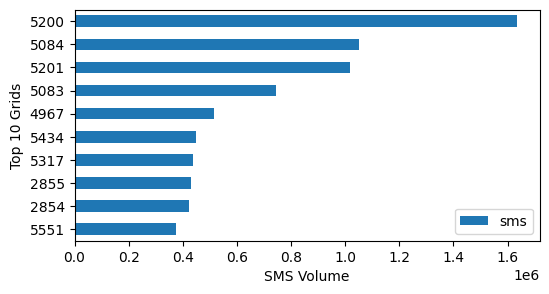

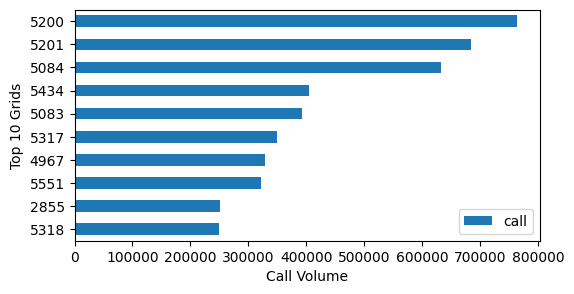

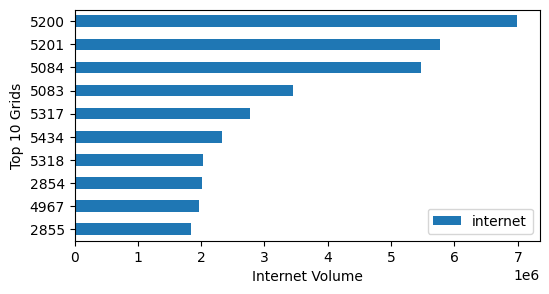

In [77]:
#Plot top 10 grids and its volume for SMS activity
ax = smsGridActivity[:10].plot(kind='barh', figsize=(6,3))
ax.invert_yaxis()
ax.set_xlabel("SMS Volume")
ax.set_ylabel("Top 10 Grids")

#Plot top 10 grids and its volume for Call activity
ax = callGridActivity[:10].plot(kind='barh', figsize=(6,3))
ax.invert_yaxis()
ax.set_xlabel("Call Volume")
ax.set_ylabel("Top 10 Grids")

#Plot top 10 grids and its volume for Internet activity
ax = internetGridActivity[:10].plot(kind='barh', figsize=(6,3))
ax.invert_yaxis()
ax.set_xlabel("Internet Volume")
ax.set_ylabel("Top 10 Grids")
plt.show()

### Mapping top 10 Grid

The top grids in the cities of **Trento and Rovereto** reveal valuable insights into the telecommunications patterns of these areas.

Trento, being the regional capital and a hub for both business and education, likely shows higher internet usage and mobile communication, especially during working hours, compared to Rovereto, which is more residential and tourist-focused.

By analyzing the data, we can uncover key trends such as peak periods for internet use and call volume, as well as differences in SMS activity. This information can help telecom companies better tailor their services, optimize infrastructure, and create targeted marketing campaigns specific to the needs of these two cities.

In [90]:
# Hover to get the grid ID

topgrids = pd.unique(top10.values.ravel())
topGridgeojson = trentino.loc[trentino['cellId'].isin(topgrids)]

m = folium.Map(location=[46.0703, 11.1216], zoom_start=10)

for _, row in topGridgeojson.iterrows():
    grid_id = row['cellId']

    folium.GeoJson(
        row['geometry'],
        tooltip=str(grid_id),  # Display the grid ID on hover
        popup=f"Grid ID: {grid_id}"  # Display the grid ID on click
    ).add_to(m)

m

### SMS, Call, Internet activity comparison in top grids

In [84]:
#get the daily volumes for the top 10 grids
daily5200 = dailyGridActivity.loc[5200][['sms','call','internet']]
daily5084 = dailyGridActivity.loc[5084][['sms','call','internet']]
daily5201 = dailyGridActivity.loc[5201][['sms','call','internet']]
daily5083 = dailyGridActivity.loc[5083][['sms','call','internet']]
daily4967 = dailyGridActivity.loc[4967][['sms','call','internet']]
daily5434 = dailyGridActivity.loc[5434][['sms','call','internet']]
daily5317 = dailyGridActivity.loc[5317][['sms','call','internet']]
daily2855 = dailyGridActivity.loc[2855][['sms','call','internet']]
daily2854 = dailyGridActivity.loc[2854][['sms','call','internet']]
daily5551 = dailyGridActivity.loc[5551][['sms','call','internet']]
daily5318 = dailyGridActivity.loc[5318][['sms','call','internet']]

##### Plot daily SMS activity for top 10 grids from Nov 1, 2013 to Nov 30, 2013

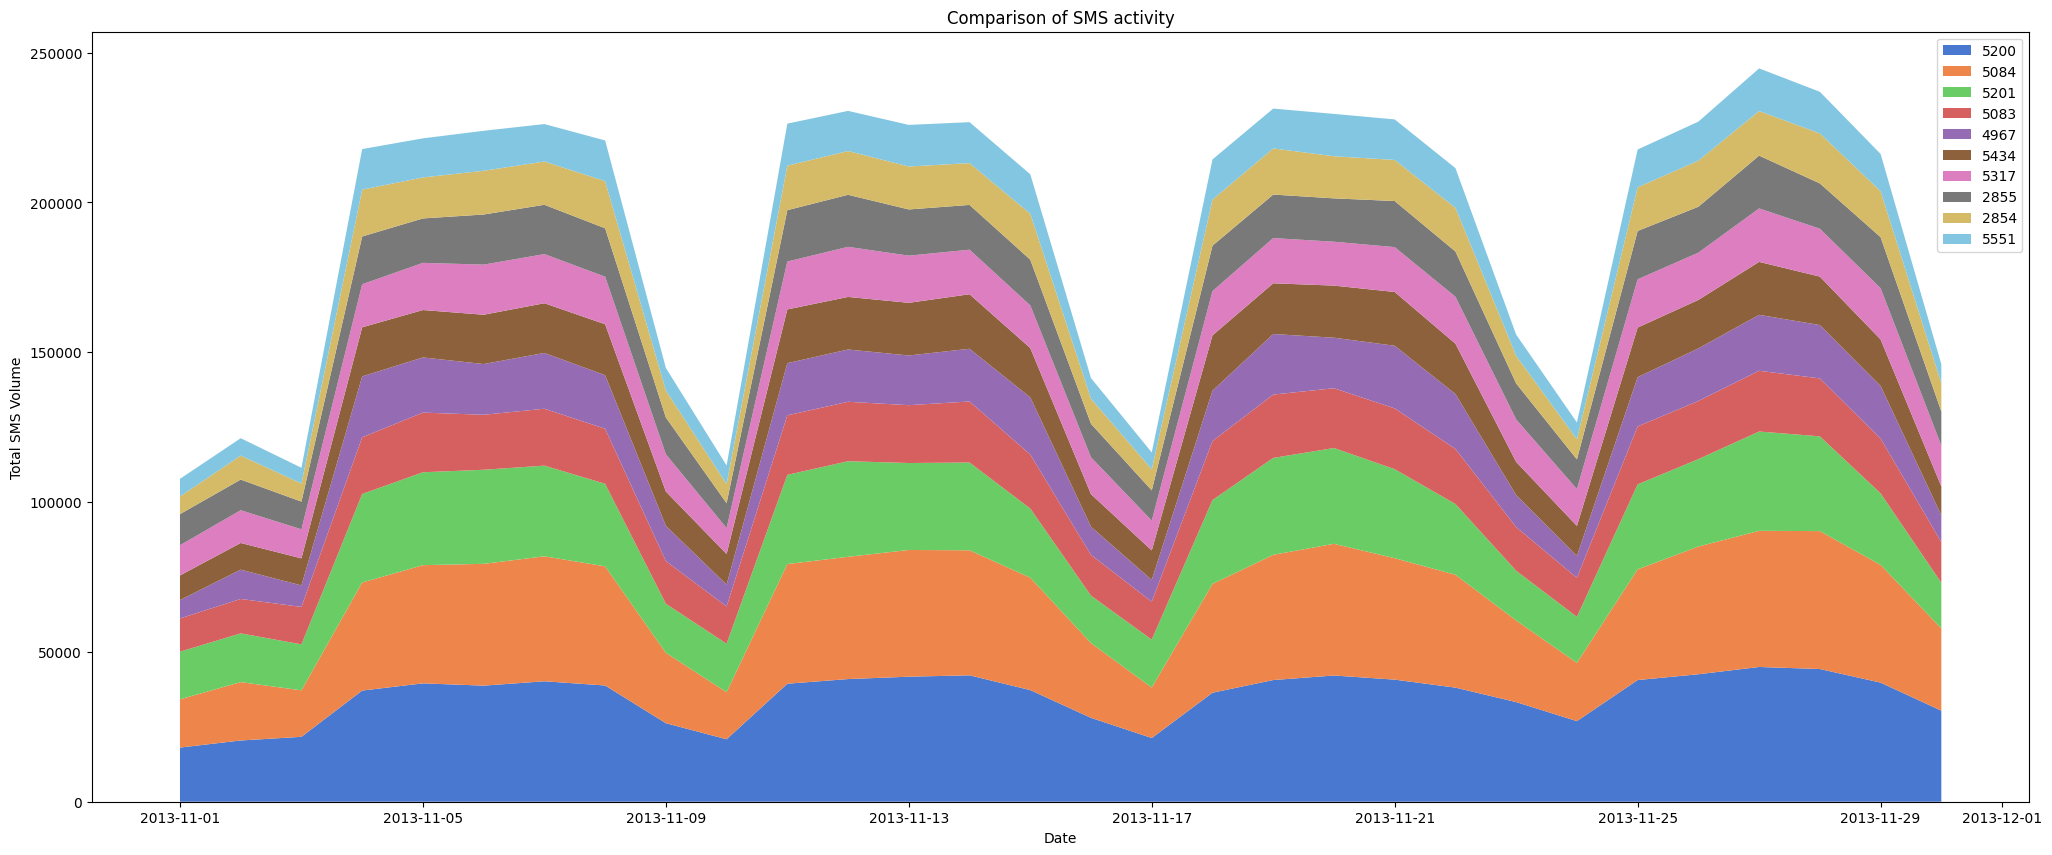

In [87]:

col = sns.color_palette("muted")
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5200.index, daily5084.sms, daily5201.sms,daily5083.sms, daily4967.sms,
                   daily5434.sms, daily5317.sms, daily2855.sms, daily2854.sms, daily5551.sms,
                   daily5318.sms, labels = top10['sms'], colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total SMS Volume')
plt.title('Comparison of SMS activity')
plt.show()

##### Plot daily Call activity for top 10 grids from Nov 1, 2013 to Nov 30, 2013

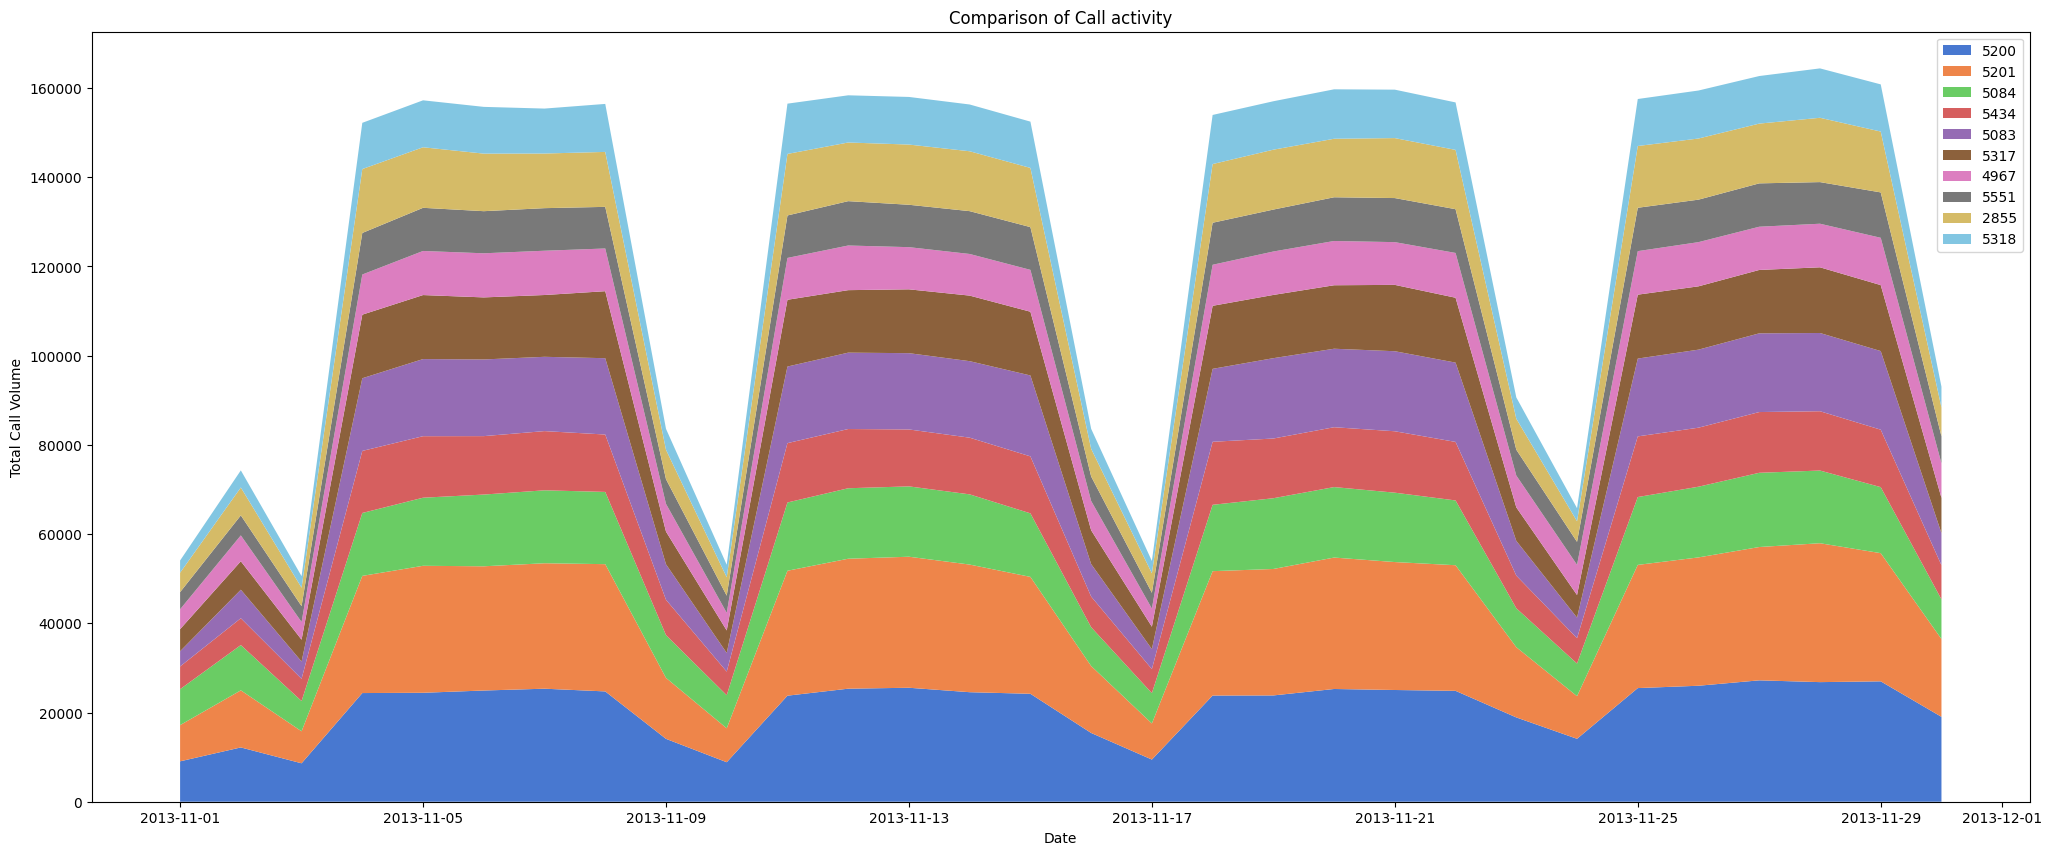

In [88]:

col = sns.color_palette("muted")
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5200.index, daily5084.call, daily5201.call,daily5083.call, daily4967.call,
                   daily5434.call, daily5317.call, daily2855.call, daily2854.call, daily5551.call,
                   daily5318.call, labels = top10['call'], colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Call Volume')
plt.title('Comparison of Call activity')
plt.show()


##### Plot daily Internet activity for top 10 grids from Nov 1, 2013 to Nov 30, 2013

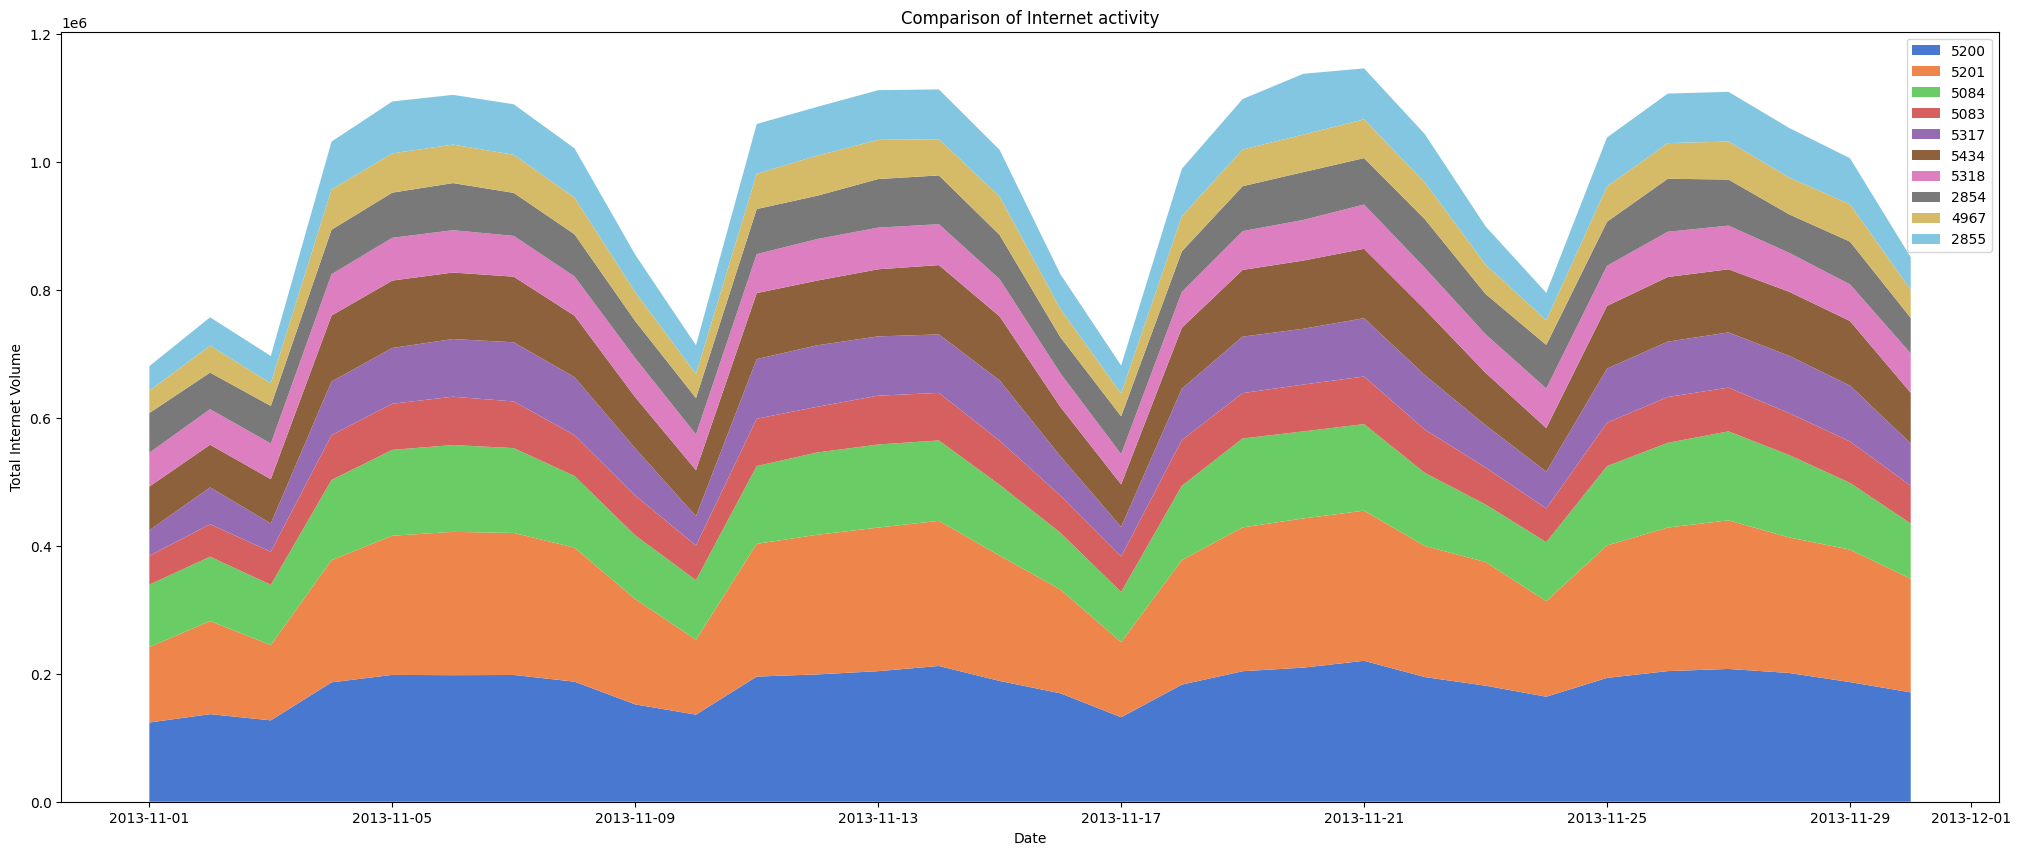

In [89]:

col = sns.color_palette("muted")
plt.figure(figsize=(25,10))
ax = plt.stackplot(daily5200.index, daily5084.internet, daily5201.internet,daily5083.internet, daily4967.internet,
                   daily5434.internet, daily5317.internet, daily2855.internet, daily2854.internet, daily5551.internet,
                   daily5318.internet, labels = top10['internet'], colors=col)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Internet Volume')
plt.title('Comparison of Internet activity')
plt.show()


### Correlation between Call, SMS, and Internet Usage (using daily data)

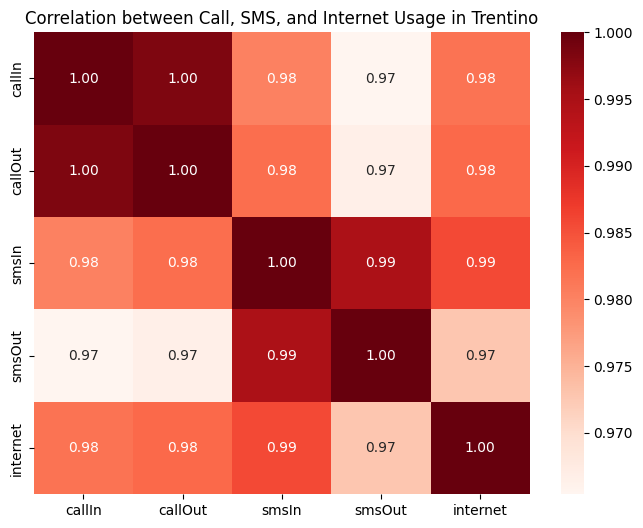

In [100]:

usage_data = dailyGridActivity.groupby(level=0)[['callIn', 'callOut', 'smsIn', 'smsOut', 'internet']].sum()
correlation_matrix = usage_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', cbar=True)
plt.title('Correlation between Call, SMS, and Internet Usage in Trentino')
plt.show()

### Comparison Daily Activity Pattern

#### In Trento (Grid 5200)

<Figure size 2500x1000 with 0 Axes>

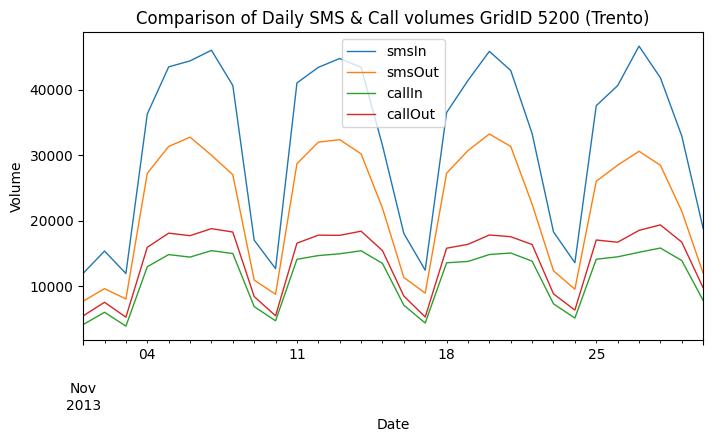

In [108]:
#Next line is to fix an error that occurs after installing FBProphet module
pd.plotting.register_matplotlib_converters()

#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for GridID 5200
daily5200 = dailyGridActivity.loc[5200]
plt.figure(figsize=(25,10))
ax = daily5200.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(8, 4), fontsize=10, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes GridID 5200 (Trento)')
# plt.axvspan('2013-11-26', '2013-11-26', color='red')
# plt.axvspan('2013-11-29', '2013-11-29', color='red')
plt.show()

#### In Rovento (Grid 2854)

<Figure size 2500x1000 with 0 Axes>

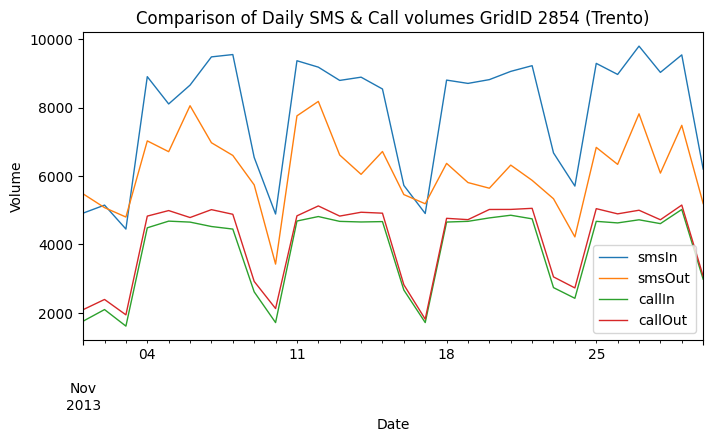

In [110]:
#Next line is to fix an error that occurs after installing FBProphet module
pd.plotting.register_matplotlib_converters()

#Plot Daily SMS-In, SMS-Out, Call-In, Call-Out activity pattern for GridID 2854
daily2854 = dailyGridActivity.loc[2854]
plt.figure(figsize=(25,10))
ax = daily2854.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(8, 4), fontsize=10, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of Daily SMS & Call volumes GridID 2854 (Trento)')
# plt.axvspan('2013-11-26', '2013-11-26', color='red')
# plt.axvspan('2013-11-29', '2013-11-29', color='red')
plt.show()

### Comparison of Hourly Activity Pattern in Grid ID 5200 (Trento) & 2854 (Rovento)

In [111]:
#Set this to None to avoid Warning messages from Pandas
pd.options.mode.chained_assignment = None

#Get hourly data for the four grids
hourly5200 = hourlyGridActivity.loc[5200]
hourly2854 = hourlyGridActivity.loc[2854]


#Add column to identify Day of the week for each observation
hourly5200['dayOfWeek'] = hourly5200.index.day_name()
hourly2854['dayOfWeek'] = hourly2854.index.day_name()


#Use pivot_table() reshape the dataframe with Mean values of the acitivities for Day of the week as columns and hours in a day as index
hourly5200_sms = hourly5200.pivot_table(index=hourly5200.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly5200_call = hourly5200.pivot_table(index=hourly5200.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly5200_internet = hourly5200.pivot_table(index=hourly5200.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')
hourly2854_sms = hourly2854.pivot_table(index=hourly2854.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly2854_call = hourly2854.pivot_table(index=hourly2854.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly2854_internet = hourly2854.pivot_table(index=hourly2854.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')


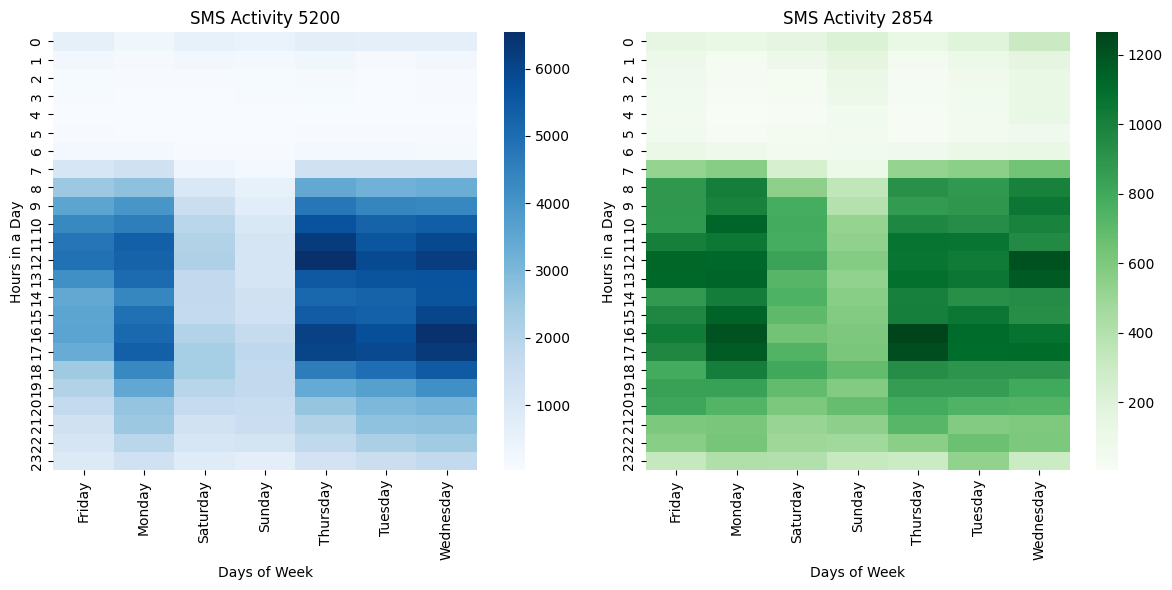

In [114]:
# From the reshaped dataframe, plot heatmap for SMS activity of the two grids
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)  # Use ncols=2 for two plots side by side

# First heatmap for grid 5200
sns.heatmap(hourly5200_sms, ax=ax[0], cmap="Blues", cbar=True)
ax[0].set_title("SMS Activity 5200")
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")

# Second heatmap for grid 2854
sns.heatmap(hourly2854_sms, ax=ax[1], cmap="Greens", cbar=True)
ax[1].set_title("SMS Activity 2854")
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")

# Adjust layout
plt.tight_layout()
plt.show()


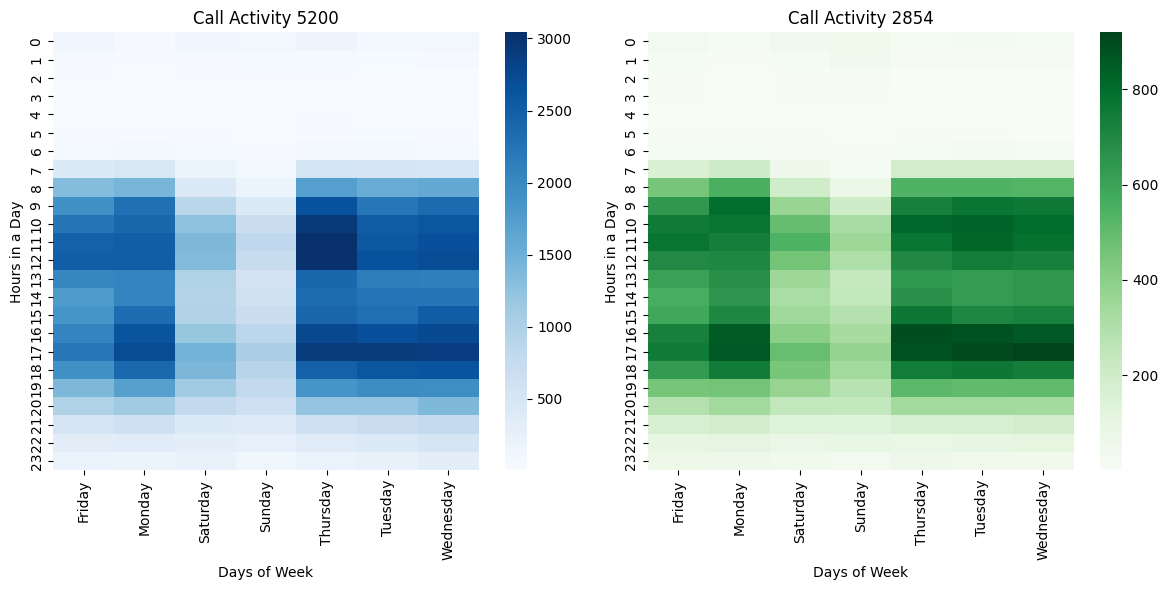

In [115]:
# From the reshaped dataframe, plot heatmap for call activity of the two grids
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)  # Use ncols=2 for two plots side by side

# First heatmap for grid 5200
sns.heatmap(hourly5200_call, ax=ax[0], cmap="Blues", cbar=True)
ax[0].set_title("Call Activity 5200")
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")

# Second heatmap for grid 2854
sns.heatmap(hourly2854_call, ax=ax[1], cmap="Greens", cbar=True)
ax[1].set_title("Call Activity 2854")
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")

# Adjust layout
plt.tight_layout()
plt.show()

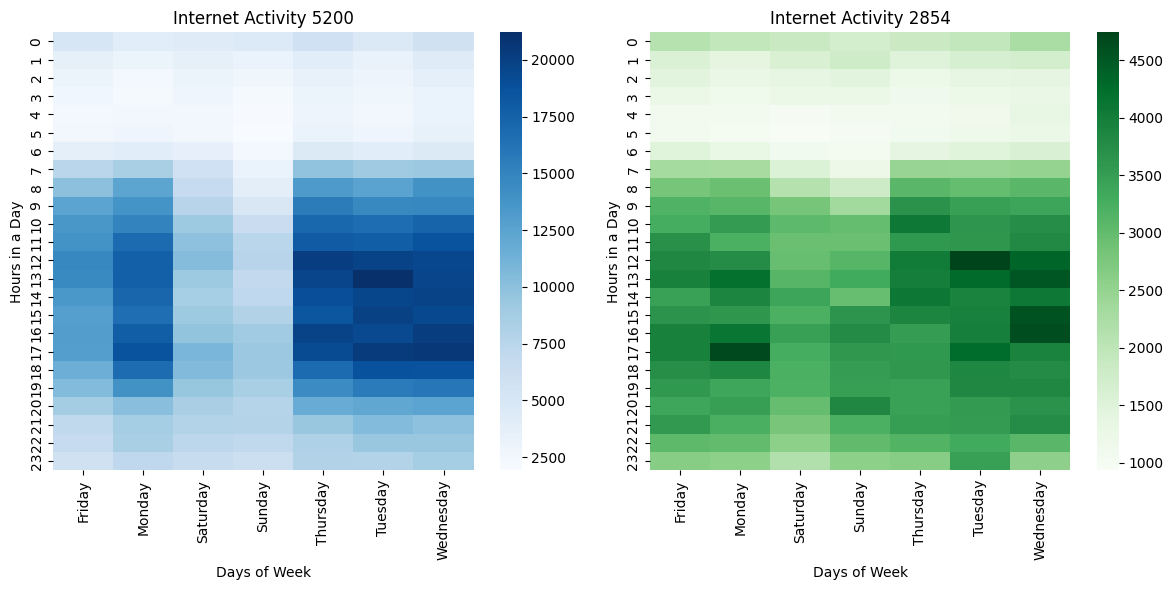

In [116]:
# From the reshaped dataframe, plot heatmap for internet activity of the two grids
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)  # Use ncols=2 for two plots side by side

# First heatmap for grid 5200
sns.heatmap(hourly5200_internet, ax=ax[0], cmap="Blues", cbar=True)
ax[0].set_title("Internet Activity 5200")
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")

# Second heatmap for grid 2854
sns.heatmap(hourly2854_internet, ax=ax[1], cmap="Greens", cbar=True)
ax[1].set_title("Internet Activity 2854")
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")

# Adjust layout
plt.tight_layout()
plt.show()


## Summary

### **Telecommunications Insights: Trentino, Italy**  

This analysis highlights key communication patterns in Trentino, focusing on **Grid 5200** (Trento) and **Grid 2854** (Rovereto). These insights help telecom companies optimize services, improve infrastructure, and design effective marketing strategies.

---

### **1. Location-Based Insights**  
#### **Trento (Grid 5200)**  
- **Top Activity:** Grid 5200 leads in SMS, calls, and internet use, reflecting Trento’s role as a hub for business and education.  
- **Opportunities:**  
  - **Optimize Networks:** Enhance infrastructure to support peak activity, especially during working hours (8:00 AM–7:00 PM).  
  - **Targeted Plans:** Introduce internet packages tailored to professionals and students.  

#### **Rovereto (Grid 2854)**  
- **Distinct Character:** Rovereto shows lower activity due to its residential and tourist-oriented nature.  
- **Opportunities:**  
  - **Tourist Packages:** Offer short-term data plans and discounts for visitors.  
  - **Efficient Investments:** Align infrastructure improvements with stable, predictable activity levels.  

---

### **2. Daily Patterns**  
#### **Recurring Activity Peaks**  
**5-Day Cycle:** Peaks occur every five days (e.g., Nov. 4–8, 11–15, 18–22, 25–29, 2013) :

    - November 4–8 (Monday–Friday)
    - November 11–15 (Monday–Friday)  
    - November 18–22 (Monday–Friday)  
    - November 25–29 (Monday–Friday)  

#### **Weekday-Weekend Trends**  
- **Observation:** Activity is lower on weekends (Saturday-Sunday) and higher midweek (Thursday-Wednesday).  
- **Opportunities:**  
  - **Weekend Engagement:** Promote entertainment bundles to boost usage on weekends.  

---

### **3. Hourly Trends**  
#### **Internet Usage**  
- **Peak Times:** 8:00 AM–7:00 PM, driven by work and education.  
- **Opportunities:**  
  - **Reliable Plans:** Offer high-speed, reliable internet packages for professionals and students.  

#### **SMS and Calls**  
- **Peak Hours:** 8:00 AM–12:00 PM and 3:00 PM–7:00 PM, aligning with commute and post-work hours.  
- **Opportunities:**  
  - **Custom Bundles:** Design SMS and call plans for these high-usage periods.  

---

### **Strategic Recommendations**  
1. **Strengthen Networks:** Focus on high-demand grids like Trento during peak times.  
2. **Tailored Marketing:**  
   - Promote work-oriented plans in Trento.  
   - Develop tourist-friendly packages for Rovereto.  
3. **Plan Around Cycles:** Leverage recurring patterns to time campaigns and allocate resources efficiently.  
4. **Boost Weekend Usage:** Offer data-driven entertainment bundles for weekends.  

---

### **Conclusion**  
Trentino's communication patterns reveal diverse needs across its cities. By leveraging these insights, telecom providers can enhance services, boost customer satisfaction, and drive revenue growth effectively.